In [1]:
import numpy as np 
import torch 
from torch.utils.data import Dataset
from epg import epg_parallel
from tqdm import tqdm 
from matplotlib import pyplot as plt 

T = 32 
TE = 9 
TR = 2800
T2_init = 200.
device = torch.device('cuda')
dtype = torch.float32
batch_size = 14000
num_epochs = 700
theta_hat_init_angle = 105.
myt2_init = 200
step_size_init_val = 3*1e6
res_arr = np.ones((288*288, 32))
t2_arr = np.ones(288*288)
pd_arr = np.ones(288*288)
pixel_norm = np.ones(288*288)

_ridx = np.random.permutation(288*288)

In [2]:
class MRIDataset(Dataset):
    """ Decoder MRI dataset with all 180 degrees"""

    # Initialize your data, download, etc.
    def __init__(self):
        rng = np.random.default_rng()
        brain = np.rot90(np.abs(np.load('notebooks/image.npy')))[:, :, 0, :].reshape(288*288, 32)
        brain_ridx = brain[_ridx, :]
        
        self.len = brain_ridx.shape[0]
        self.y_data = brain_ridx
        self.t1_data = torch.tensor(np.ones(brain_ridx.shape[0])*1000., dtype=torch.float32)

    def __getitem__(self, index):
        return self.t1_data[index], self.y_data[index, :]

    def __len__(self):
        return self.len


In [3]:
def pbnet(y_meas, theta_hat, step_size, TE, TR, T1, testFlag=True):
    '''
    y_meas: [batch_size, T] -- Input Signal
    theta: [1, T] -- Flip angles
    '''
    myt2 = torch.ones((y_meas.shape[0]), dtype=torch.float32, requires_grad=True, device=theta_hat.device)*T2_init
    if testFlag: y_meas = y_meas.detach()
    sig_est = None 
    loss = None
    for kk in range(num_epochs):
        sig_est = epg_parallel.FSE_signal_TR(theta_hat, TE, TR, T1, myt2, B1=1.).squeeze()
        rho_est = torch.sum(y_meas * sig_est, axis=1) / torch.sum(sig_est * sig_est, axis=1)
        sig_est = rho_est[:, None] * sig_est
        residual = y_meas - sig_est
        loss = torch.sum(residual**2)
        
        g = torch.autograd.grad(loss, 
                                myt2, 
                                create_graph = not testFlag)[0]
        
        myt2 = myt2 - step_size*g 
    return myt2, sig_est, loss, rho_est

In [4]:
dataset = MRIDataset()
data_loader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size = batch_size,
    num_workers = 2,
    drop_last = False,
    shuffle = False
)  

In [5]:
final_theta = np.ones((1, T))*theta_hat_init_angle
theta_hat_init =  torch.tensor(
            final_theta/180*np.pi, dtype=torch.float32).to(device)
theta_hat = theta_hat_init.detach().clone()
theta_hat.requires_grad = True

step_size_init = torch.tensor([step_size_init_val], dtype=torch.float32).to(device)
step_size = step_size_init.detach().clone()
step_size.requires_grad = True

In [6]:
%%time
for i, (T1, y) in tqdm(enumerate(data_loader)):
    t1 = T1.to(device)
    y_m = y.to(device) 
    y_norm = torch.norm(y_m)
    y_meas = y_m / y_norm
    myt2, y_est, loss, pd = pbnet(y_meas, theta_hat, step_size, TE, TR, t1, testFlag=True)
    res_arr[i*batch_size: i*batch_size + y.shape[0]] = y_est.detach().cpu().numpy()
    t2_arr[i*batch_size: i*batch_size + y.shape[0]] = myt2.detach().cpu().numpy()
    pixel_norm[i*batch_size: i*batch_size + y.shape[0]] = y_norm.detach().cpu().numpy()
    pd_arr[i*batch_size: i*batch_size + y.shape[0]] = pd.detach().cpu().numpy()

6it [09:05, 90.84s/it]

CPU times: user 8min 42s, sys: 22.5 s, total: 9min 5s
Wall time: 9min 5s


In [7]:
t2_map_sorted = np.zeros(t2_arr.shape)
pd_map_sorted = np.zeros(pd_arr.shape)
for i in range(t2_map_sorted.shape[0]):
    t2_map_sorted[_ridx[i]] = t2_arr[i]
    pd_map_sorted[_ridx[i]] = pd_arr[i]

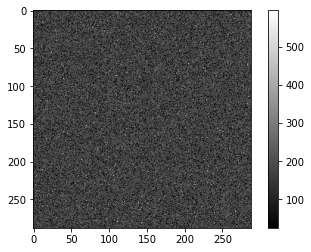

In [8]:
%matplotlib inline
plt.imshow(t2_arr.reshape(288,288), cmap='gray')
plt.colorbar()

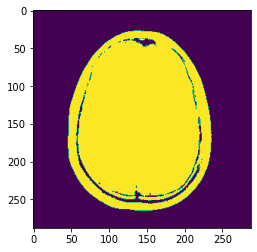

In [9]:
brain = np.rot90(np.abs(np.load('notebooks/image.npy')))[:, :, 0, :].reshape(288*288, 32)
m1 = np.linalg.norm(brain, axis=1)
mask = m1 > np.max(m1)*.05
plt.imshow(mask.reshape((288,288)))

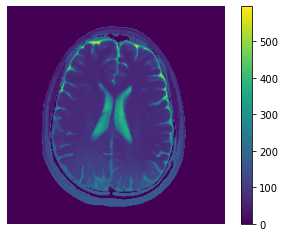

In [10]:
%matplotlib inline

plt.imshow(t2_map_sorted.reshape(288,288)*mask.reshape(288, 288))
plt.axis('off')
plt.colorbar()
plt.savefig('t2.png', bbox_inches='tight')

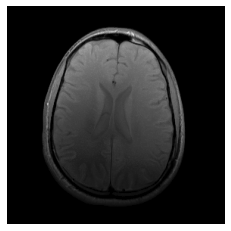

In [11]:
%matplotlib inline 
plt.figure()
plt.imshow(pd_map_sorted.reshape(288,288)*mask.reshape(288, 288), cmap='gray')
plt.axis('off')
plt.savefig('pd.png', bbox_inches='tight')

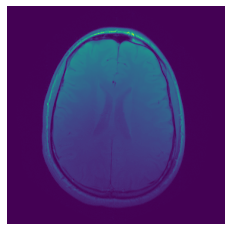

In [12]:
brain = np.rot90(np.abs(np.load('notebooks/image.npy')))
plt.figure()
plt.axis('off')
plt.imshow(brain[:, :, 0, 0])